In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from neuralop.models import FNO,FNO1d
from neuralop.training import Trainer
from neuralop.data.datasets.tensor_dataset import TensorDataset

from torchsummary import summary

# Learning Operators with FNO
Hackers: Aaron Mäkel, Fynn


In [2]:

def generate_random_funcs(func_num,sensor_points_num=100): #func_num=how many functions to generate
    sensor_points = torch.linspace(0,2*math.pi,sensor_points_num) #create equidistant sensor points

    p_sin = torch.randn(func_num,1) #sample from standard normal: shape (func_num,1)
    p_cos = torch.randn(func_num,1)
    f = p_sin*torch.sin(sensor_points)[None,:] + p_cos*torch.cos(sensor_points)[None,:] #[None,:] adds batch dimension -> (1,m) -> f is (func_num,m)
    
    Phi = torch.tensor([[0.0,-1.0],[1.0,0.0]]) #Known matrix for our problem
    v = torch.cat([p_sin,p_cos],dim=1).T #obtain v of shape (2, func_num)
    result = torch.matmul(Phi,v) #result (2,func_num)
    f_der = result[0][:,None]*torch.sin(sensor_points)[None,:] + result[1][:,None]*torch.cos(sensor_points)[None,:]
    return f,f_der,sensor_points


### Generate Test data

True


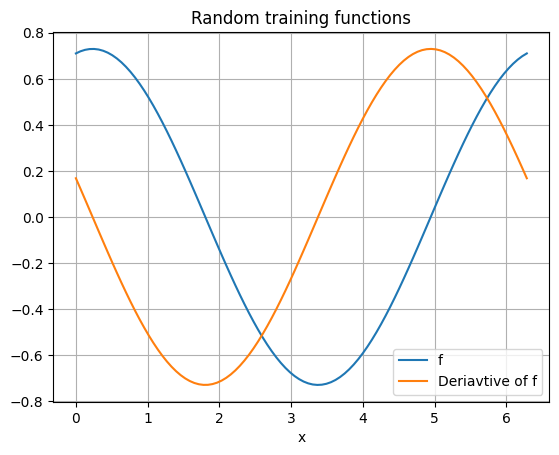

In [19]:
f,f_der,sensor_points = generate_random_funcs(1,100)

print(f.shape == f_der.shape)

plt.plot(sensor_points,f[0,:].squeeze(),label="f")
plt.plot(sensor_points,f_der[0,:].squeeze(),label="Deriavtive of f") #squeeze removes all dimensions from size 1
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()

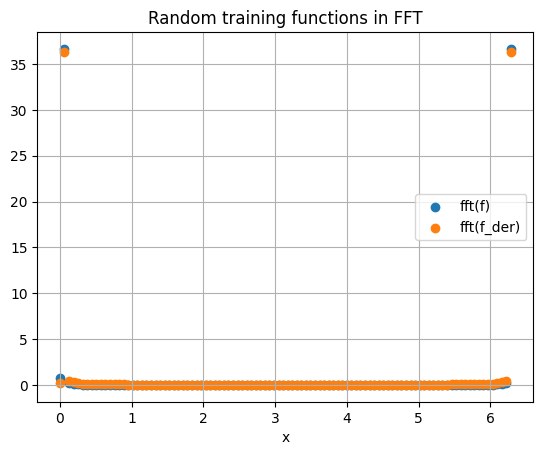

In [20]:
#plt.plot(sensor_points,fft(f_der[3,:].squeeze().detach().numpy()),label="Deriavtive of Function") #squeeze removes all dimensions from size 1
plt.scatter(sensor_points,np.abs(fft(f[0,:].squeeze().detach().numpy())),label="fft(f)")
plt.scatter(sensor_points,np.abs(fft(f_der[0,:].squeeze().detach().numpy())),label="fft(f_der)")

plt.grid()
#plt.yscale('log')
plt.xlabel("x")
plt.title("Random training functions in FFT")
plt.legend()

### Data Generation:


IMPORTANT: 

[FUNCTION NUMBER] x [SENSOR POINTS] :WILL BREAK THE PROGRAM WITHOUT TELLING YOU DIRECTLY WHY.

[FUNCTION NUMBER] x [1] x [SENSOR POINTS] IS THE NEEDED FORMAT

In [5]:
f, f_der, _ = generate_random_funcs(1100,100)
f_precise, f_der_precise, _ = generate_random_funcs(100,1000)

#Data Formatting
f_formatted = f.unsqueeze(1)
f_der_formatted = f_der.unsqueeze(1)
f_precise =f_precise.unsqueeze(1)
f_der_precise = f_der_precise.unsqueeze(1)


dataset_train = TensorDataset(f_formatted[:1000], f_der_formatted[:1000])
dataset_test = TensorDataset(f_formatted[1000:], f_der_formatted[1000:])
dataset_precise = TensorDataset(f_precise, f_der_precise)
print(dataset_test.x.shape)
#Split into batches
batch_size = 32

train_loader = DataLoader(dataset_train, 
                                batch_size=batch_size,
                                shuffle=True)

test_loader = DataLoader(dataset_test, 
                                batch_size=batch_size, 
                                shuffle=True)
test_loader_precise = DataLoader(dataset_precise, 
                                batch_size=batch_size, 
                                shuffle=True)

test_loader = {100:test_loader,1000:test_loader_precise}

data = train_loader.dataset[0]
x = data['x']
y = data['y']

print(f'Training samples have shape {x.shape}')

torch.Size([100, 1, 100])
Training samples have shape torch.Size([1, 100])


### FNO Model

In [6]:
n_modes = (2,)
hidden_channels = 2
n_layers = 1

model = FNO(
    n_modes= n_modes,
    hidden_channels=hidden_channels, #lowest tested is 4
    in_channels=1,
    out_channels=1,
    n_layers = n_layers,

    positional_embedding=None,
    #non_linearity (activation function ,default: GELU)
    use_channel_mlp=False# (mlp after each FNO layer?)
        #channel_mlp_dropout (default 0)
        #channel_mlp_expansion ( default 0.5)
        #channel_mlp_skip (skip type, default softgating)
    #lifting_channel_ratio (to hidden channel)
    #projection_channel_ratio (to hidden channel)
   
    #norm (normalization layer, default none)
    #complex_data:bool
    
    #fno_skip (skip type in fno layers, default linear
    #resolution_scaling_factor: number or list, use different resolutions at different layers)
    #domain_padding 
        #domain_padding_mode: default symmetric
    #fno_block_precision default full
    #stabilizer: bool, use tanh stabilizer in fno block?
    #max_n_modes increase max nodes during traing, default full number of n_modes used each epoch.
    #factorization: tensor factorization
        #rank: tensor rank
        #fixed_rank_modes
        #implementation
        #decomposition_kwargs
    #separable: depthwise seperable spectral convolution, default false
    #preactivation: whether to compute FNO forward pass with resnet-style preactivation, by default False
    #conv_module: module to use for FNOBlock’s convolutions, by default SpectralConv
)



<img src="RELU.jpg" alt="drawing" width="400"/>
<img src="GELU.jpg" alt="drawing" width="400"/>


In [7]:
#TORCHSUMMARY DOESNT WORK :(
pytorch_total_params = sum(p.numel() for p in model.parameters())


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
print('')
print('Total parameters:',pytorch_total_params)

fno_blocks.convs.0.bias 2
fno_blocks.convs.0.weight.tensor 8
fno_blocks.fno_skips.0.conv.weight 4
lifting.fcs.0.weight 4
lifting.fcs.0.bias 4
lifting.fcs.1.weight 8
lifting.fcs.1.bias 2
projection.fcs.0.weight 8
projection.fcs.0.bias 4
projection.fcs.1.weight 4
projection.fcs.1.bias 1

Total parameters: 49



Lifting:    18

FNO_blocks: 14

Projection: 17

we have 49 parameters, compared to 1160 from last time.

In [8]:
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.3) 

# Create the trainer
trainer = Trainer(model=model, n_epochs=n_epochs ,
                  verbose=True)


final_eval = trainer.train(train_loader=train_loader,
           test_loaders=test_loader,
           optimizer=optimizer,
           scheduler=scheduler
           #training_loss, for custom training losses.
           #eval_losses= dict of loss functions
           )
           
           


Training on 1000 samples
Testing on [100, 100] samples         on resolutions [100, 1000].
Raw outputs of shape torch.Size([32, 1, 100])
[0] time=0.15, avg_loss=1.3019, train_err=40.6832
Eval: 100_l2=1.3353, 1000_l2=1.2390
[1] time=0.12, avg_loss=1.1705, train_err=36.5779
Eval: 100_l2=1.1752, 1000_l2=1.1179
[2] time=0.12, avg_loss=1.0653, train_err=33.2909
Eval: 100_l2=1.0481, 1000_l2=1.0235
[3] time=0.12, avg_loss=0.9901, train_err=30.9394
Eval: 100_l2=0.9670, 1000_l2=0.9636
[4] time=0.13, avg_loss=0.9469, train_err=29.5908
Eval: 100_l2=0.9279, 1000_l2=0.9282
[5] time=0.13, avg_loss=0.9023, train_err=28.1960
Eval: 100_l2=0.8634, 1000_l2=0.8641
[6] time=0.12, avg_loss=0.8049, train_err=25.1540
Eval: 100_l2=0.7147, 1000_l2=0.7168
[7] time=0.13, avg_loss=0.5826, train_err=18.2054
Eval: 100_l2=0.3802, 1000_l2=0.3899
[8] time=0.13, avg_loss=0.2060, train_err=6.4366
Eval: 100_l2=0.1305, 1000_l2=0.1255
[9] time=0.13, avg_loss=0.0982, train_err=3.0690
Eval: 100_l2=0.0833, 1000_l2=0.0847
[10] 

### Testing the trained model

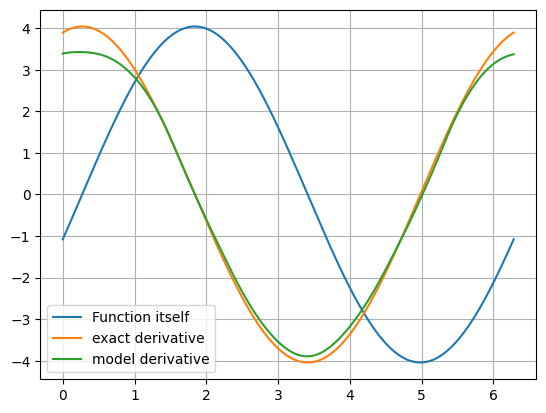

In [14]:
test_in,test_out,sensor_points = generate_random_funcs(1,1000)
test_oper = model(test_in.unsqueeze(0))

plt.plot(sensor_points, test_in.squeeze().detach().numpy(), label="Function itself")
plt.plot(sensor_points, test_out.squeeze().detach().numpy(), label="exact derivative")
plt.plot(sensor_points, test_oper.squeeze().detach().numpy(), label="model derivative")
plt.legend()
plt.grid()
plt.show()

### Evaluation

for detailed training statistics, use wandb API or extract from console output.


In [10]:
for e in final_eval:
    print(e,': ',final_eval[e])

train_err :  0.7125633507966995
avg_loss :  0.022802027225494386
avg_lasso_loss :  None
epoch_train_time :  0.12343269999837503
100_l2 :  tensor(0.0232)
1000_l2 :  tensor(0.0091)


<img src="wandb.jpg" alt="drawing" />